In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from astropy.io import fits
from astropy.table import Table
from astropy.visualization import simple_norm
from astropy.utils.data import download_file

from jwst import datamodels

from specreduce.extract import BoxcarExtract

In [2]:
# data is taken from s2d file. x1d is used for comparison with pipeline extraction.
s2dfilename = "nirspec_fssim_d1_s2d.fits"
x1dfilename = "nirspec_fssim_d1_x1d.fits"
mainurl = "file:/Users/busko/Downloads/NIRSpec_s2d/"

s2dfile_dld = download_file(mainurl + s2dfilename)
x1dfile_dld = download_file(mainurl + x1dfilename)

In [3]:
# rename files so that they have the right extensions required for the jwst datamodels to work
s2dfile = s2dfile_dld + '_s2d.fits'
os.rename(s2dfile_dld, s2dfile)
x1dfile = x1dfile_dld + '_x1d.fits'
os.rename(x1dfile_dld, x1dfile)

In [4]:
# use a jwst datamodel to provide a good interface to the data and wcs info
s2d = datamodels.open(s2dfile)
image = s2d.slits[0].data

Text(0.5, 1.0, 'slit[0]')

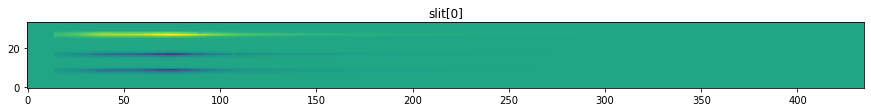

In [5]:
# display s2d image
norm_data = simple_norm(image, "sqrt")
plt.figure(figsize=(15, 15))
plt.imshow(image, norm=norm_data, origin="lower")
plt.title("slit[0]")

<TableColumns names=('WAVELENGTH','FLUX','ERROR','SURF_BRIGHT','SB_ERROR','DQ','BACKGROUND','BERROR','NPIXELS')>


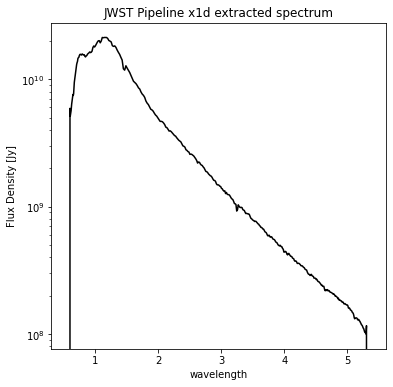

In [6]:
# pipeline 1d extraction (for comparison)
jpipe_x1d = Table.read(x1dfile, hdu=1)
print(jpipe_x1d.columns)
# plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(jpipe_x1d['WAVELENGTH'], jpipe_x1d['FLUX'], 'k-', label="jpipe_x1d")
ax.set_title("JWST Pipeline x1d extracted spectrum")
ax.set_xlabel("wavelength")
ax.set_ylabel("Flux Density [Jy]")
ax.set_yscale("log")

Text(0.5, 1.0, 'slit[0] slice')

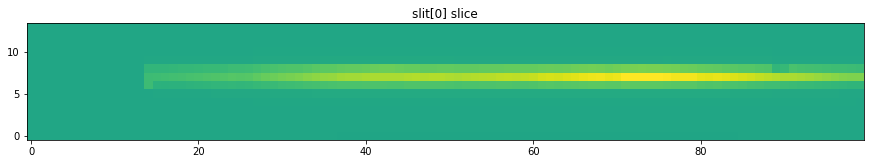

In [7]:
# blow up of the region to be extracted
plt.figure(figsize=(15, 15))
plt.imshow(image[20:35,0:100], norm=norm_data, origin="lower")
plt.title("slit[0] slice")

In [15]:
# extraction parameters based on image above
ext_center = 27
ext_width = 6
bkg_offset = 6
bkg_width = 2

Text(0.5, 1.0, 'Cross-dispersion Cut at Pixel=70')

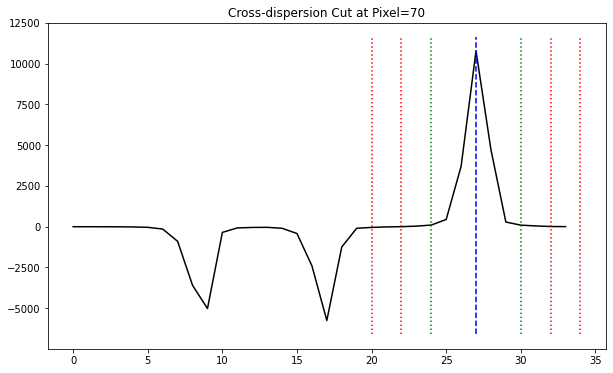

In [16]:
# Plot along cross-disperion cut showing the extraction parameters
fig, ax = plt.subplots(figsize=(10, 6))
y = np.arange(image.shape[0])
ax.plot(y, image[:,70], 'k-')
mm = np.array([ext_center, ext_center])
mm_y = ax.get_ylim()

ax.plot(mm, mm_y, 'b--')
ax.plot(mm - ext_width/2., mm_y, 'g:')
ax.plot(mm + ext_width/2., mm_y, 'g:')

ax.plot(mm - bkg_offset - bkg_width/2., mm_y, 'r:')
ax.plot(mm - bkg_offset + bkg_width/2., mm_y, 'r:')
ax.plot(mm + bkg_offset - bkg_width/2., mm_y, 'r:')
ax.plot(mm + bkg_offset + bkg_width/2., mm_y, 'r:')

ax.set_title("Cross-dispersion Cut at Pixel=70")

In [18]:
# build a trace object
class Trace:
    def __init__(self, image, ext_center):
        self.line = np.ones(shape=(image.shape[1]), dtype=int) * ext_center

trace = Trace(image, ext_center)

boxcar = BoxcarExtract()
boxcar.apwidth = ext_width
boxcar.skysep = int(bkg_offset - bkg_width/2 - ext_width/2)
boxcar.skywidth = bkg_width

spectrum, bkg_spectrum = boxcar(image, trace)

2
@@@@  extract.py-97: sky extraction region(s) indices:  [17 18]


In [11]:
print(spectrum.wavelength)

UnitConversionError: 'pix' and 'Angstrom' (length) are not convertible

In [ ]:
# plot

# fig, ax = plt.subplots(figsize=(6, 6))
# ax.plot(spectrum.wavelength.values, spectrum.flux.values, 'k-', label="boxcar")
# ax.plot(waves_boxcar_bkgsub[gpts], ext1d_boxcar_bkgsub[gpts], 'k:', label="boxcar (bkgsub)")
# ax.plot(jpipe_x1d['WAVELENGTH'], jpipe_x1d['FLUX'], 'k-', label="jpipe_x1d")
# ax.set_title("Fixed boxcar 1D extracted spectrum")
# ax.set_xlabel(r"wavelength [$\mu$m]")
# ax.set_ylabel("Flux Density [Jy]")
# ax.set_yscale("log")
# ax.legend()

## About this notebook

**Author:** Ivo Busko, JWST
**Updated On:** 2021-12-01

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 